# 1. Introduction

First let's import a dataset. Download it to your local storage and import it here. (Run the following snippet to upload the file)

In [1]:
# Import dataset file to Colab
from google.colab import files
uploaded = files.upload()

# Import generalized dataset as well
generalized = files.upload()

Saving input_dataset_11758_sessions.csv to input_dataset_11758_sessions.csv


Saving generalized_dataset.csv to generalized_dataset.csv


The uploaded variable has a list of the uploaded files. We are going to keep only the first one.

In [2]:
dataset_filename = list(uploaded.keys())[0]

print(dataset_filename)

input_dataset_11758_sessions.csv


## 1.1 Importing the CSV to the notebook

Now that we have uploaded the file to Colab we will play with some basic operations to get the feeling. In the end we have to define our classes for the Machine Learning model. For data manipulation we will be using python library called "Pandas"

In [3]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data and display first rows
df_input = pd.read_csv(dataset_filename)
df_input.head()

,id,bw,duration,packets,data_pkts,data_bytes,rexmit_pkts,rexmit_bytes,rtt_avg,rtt_min,rtt_max,stdev_rtt,rtt_count,reordering,ttl_min,ttl_max,max_seg_size,min_seg_size,win_max,win_min,rtx_RTO,rtx_FR,net_dup,flow_control,unnece_rtx_RTO,stallCount,qualityChanges,skippedFrames,fpsChanges,twitch_backend
0,3577,5.0,60.0,10.0,4.0,2421.000000,0.0,0.0,15.536362,14.849000,16.015000,0.494797,4.0,0.0,64.0,1448.000000,80.000000,64256.000000,57216.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,47,6,1.7.0-twitch.1-rc.1
1,3422,5.0,60.0,12.0,4.0,2322.000000,0.0,0.0,16.080478,14.766000,18.314000,1.322781,5.0,0.0,64.0,1448.000000,80.000000,64256.000000,57216.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1.7.0-twitch.1-rc.1
2,3427,5.0,60.0,10.0,4.0,2411.000000,0.0,0.0,15.403615,15.084000,15.881000,0.338309,4.0,0.0,64.0,1448.000000,80.000000,64256.000000,58368.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,3,6,1.7.0-twitch.1-rc.1
3,3418,1.0,60.0,2612.0,69.0,12533.333333,1.0,1411.0,37.896837,30.723667,77.964000,14.536611,72.0,0.0,64.0,1189.666667,72.166667,216445.333333,59450.666667,0.0,0.0,0.0,0.0,1.0,0.0,1,4,1,5,1.7.0-twitch.1-rc.1
4,3421,4.0,60.0,59.0,11.0,2904.666667,0.0,0.0,58.047439,54.201667,69.851667,6.926492,15.0,0.0,64.0,980.333333,82.333333,64256.000000,61824.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,4,1.7.0-twitch.1-rc.1


In [4]:
df_input.columns

Index(['id', 'bw', 'duration', 'packets', 'data_pkts', 'data_bytes',
       'rexmit_pkts', 'rexmit_bytes', 'rtt_avg', 'rtt_min', 'rtt_max',
       'stdev_rtt', 'rtt_count', 'reordering', 'ttl_min', 'ttl_max',
       'max_seg_size', 'min_seg_size', 'win_max', 'win_min', 'rtx_RTO',
       'rtx_FR', 'net_dup', 'flow_control', 'unnece_rtx_RTO', 'stallCount',
       'qualityChanges', 'skippedFrames', 'fpsChanges', 'twitch_backend'],
      dtype='object')

Let's get the range of **quality changes** that we have in the dataset

In [5]:
# Print the different number of quality changes in the dataset
print("Quality changes: ", set(df_input['qualityChanges']))

Quality changes:  {1, 2, 3, 4, 5, 6, 7, 8, 9}


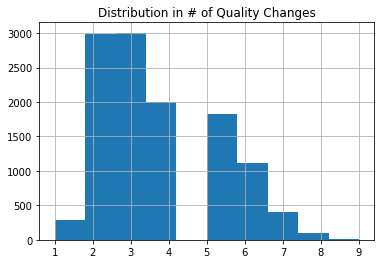

In [6]:
import matplotlib.pyplot as plt
plt.title("Distribution in # of Quality Changes")
df_input['qualityChanges'].hist()

Let's get the range of **stall numbers** that we have in the dataset

In [7]:
# Print the different number of quality changes in the dataset

print("Stall count: ", set(df_input['stallCount']))

Stall count:  {0, 1, 2, 3, 4, 5, 7}


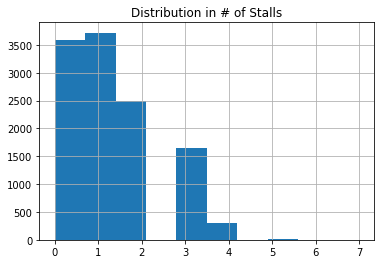

In [8]:
import matplotlib.pyplot as plt
plt.title("Distribution in # of Stalls")
df_input['stallCount'].hist()

# 2. Labeling the dataset

Now that we get an insight over the application data from twitch, it is time to decide how we are going to define the different quality classes. The new column that represents the label is called *qoe_class*

Remember that we need to make sure that our classes will result in a balanced dataset so that the ML algorithm is as robust as possible.

## 2.1 Binary Classification (Good Quality if no stalls) 

---


One option is to implement the **Binary classification** based on the number of stalls. In other words, we map good quality if # of stalls < Threshold. Otherwise, the session is of low quality.

In [9]:
threshold=1

df_input.loc[(df_input['stallCount']<threshold), 'qoe_class_1'] = "0" # Stands for good quality
df_input.loc[(df_input['stallCount']>=threshold), 'qoe_class_1'] = "1" # Stands for bad quality

In [10]:
df_input['qoe_class_1']

0        0
1        0
2        0
3        1
4        0
        ..
11753    0
11754    1
11755    0
11756    0
11757    0
Name: qoe_class_1, Length: 11758, dtype: object

### Labeling Results
Let's see how balanced dataset we managed to have, based on this labeling technique

Counter({'1': 8177, '0': 3581})


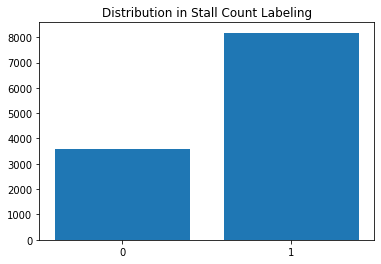

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

plt.title("Distribution in Stall Count Labeling")
plt.bar(dict(Counter(df_input['qoe_class_1'])).keys(), dict(Counter(df_input['qoe_class_1'])).values())

print(Counter(df_input['qoe_class_1']))


### Imbalanced Dataset ( **Disclaimer**: It is not needed for this dataset. It is just left for proof of concept)

What happens in the case where the dataset is inevitable imbalanced. In binary classification (where we have to label/classes) we can define the majority and the minority class. Here we have two approaches to balance the datases:

*  Up-sampling the minority class
*  Down-sampling the majority class



<BarContainer object of 2 artists>

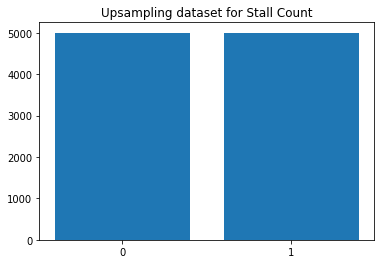

In [12]:
from sklearn.utils import resample

# Up-sampling

# Separate majority and minority classes
df_class_1 = df_input[df_input['qoe_class_1']=='0']
df_class_2 = df_input[df_input['qoe_class_1']=='1']

# Upsample minority class
df_class_1_upsampled = resample(df_class_1, 
                     replace=True,     # sample with replacement
                     n_samples=5000,   # to match majority class
                     random_state=123) # reproducible results

# Upsample minority class
df_class_2_upsampled = resample(df_class_2, 
                     replace=True,     # sample with replacement
                     n_samples=5000,   # to match majority class
                     random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_binary_resampled = pd.concat([df_class_1_upsampled, df_class_2_upsampled])

plt.title("Upsampling dataset for Stall Count")
plt.bar(dict(Counter(df_binary_resampled['qoe_class_1'])).keys(), dict(Counter(df_binary_resampled['qoe_class_1'])).values())

## 2.2 Three-class Classification (Good Quality -> max. 1 quality change; Bad Quality -> more than 3 quality changes)
A second option is to implement the **3 class Classification** based on the number of quality changes. Now we need to define 2 thresholds: One for high quality and one for low quality. If the session does not satisfy either one of those two then it belongs to medium class.



In [13]:
high_quality_threshold=2
low_quality_threshold=3


df_input.loc[(df_input['qualityChanges']<high_quality_threshold), 'qoe_class_2'] = "0" # Stands for good quality
df_input.loc[(df_input['qualityChanges']>=high_quality_threshold) &(df_input['qualityChanges']<=low_quality_threshold), 'qoe_class_2'] = "1" # Stands for medium quality
df_input.loc[(df_input['qualityChanges']>low_quality_threshold), 'qoe_class_2'] = "2" # Stands for bad quality

df_input.head()

,id,bw,duration,packets,data_pkts,data_bytes,rexmit_pkts,rexmit_bytes,rtt_avg,rtt_min,rtt_max,stdev_rtt,rtt_count,reordering,ttl_min,ttl_max,max_seg_size,min_seg_size,win_max,win_min,rtx_RTO,rtx_FR,net_dup,flow_control,unnece_rtx_RTO,stallCount,qualityChanges,skippedFrames,fpsChanges,twitch_backend,qoe_class_1,qoe_class_2
0,3577,5.0,60.0,10.0,4.0,2421.000000,0.0,0.0,15.536362,14.849000,16.015000,0.494797,4.0,0.0,64.0,1448.000000,80.000000,64256.000000,57216.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,47,6,1.7.0-twitch.1-rc.1,0,1
1,3422,5.0,60.0,12.0,4.0,2322.000000,0.0,0.0,16.080478,14.766000,18.314000,1.322781,5.0,0.0,64.0,1448.000000,80.000000,64256.000000,57216.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,1.7.0-twitch.1-rc.1,0,0
2,3427,5.0,60.0,10.0,4.0,2411.000000,0.0,0.0,15.403615,15.084000,15.881000,0.338309,4.0,0.0,64.0,1448.000000,80.000000,64256.000000,58368.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,3,6,1.7.0-twitch.1-rc.1,0,1
3,3418,1.0,60.0,2612.0,69.0,12533.333333,1.0,1411.0,37.896837,30.723667,77.964000,14.536611,72.0,0.0,64.0,1189.666667,72.166667,216445.333333,59450.666667,0.0,0.0,0.0,0.0,1.0,0.0,1,4,1,5,1.7.0-twitch.1-rc.1,1,2
4,3421,4.0,60.0,59.0,11.0,2904.666667,0.0,0.0,58.047439,54.201667,69.851667,6.926492,15.0,0.0,64.0,980.333333,82.333333,64256.000000,61824.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,4,1.7.0-twitch.1-rc.1,0,1


### Labeling Results
Let's see how balanced dataset we managed to have, based on this labeling technique

Counter({'1': 5995, '2': 5477, '0': 286})


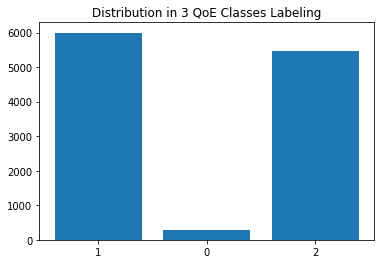

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

plt.title("Distribution in 3 QoE Classes Labeling")
plt.bar(dict(Counter(df_input['qoe_class_2'])).keys(), dict(Counter(df_input['qoe_class_2'])).values())

print(Counter(df_input['qoe_class_2']))

### Imbalanced Dataset ( **Disclaimer**: This needs to be adjusted each time you import a new dataset)

We perform similar operations. Specifically, in this case we will be up-sampling the two smaller classes to reach the largest one.

<BarContainer object of 3 artists>

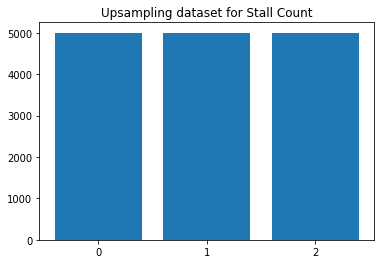

In [15]:
from sklearn.utils import resample

# Up-sampling

# Separate majority and minority classes
df_class_0 = df_input[df_input['qoe_class_2']=='0']
df_class_1 = df_input[df_input['qoe_class_2']=='1']
df_class_2 = df_input[df_input['qoe_class_2']=='2']

# Upsample minority class
df_class_0_upsampled = resample(df_class_0, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=123) # reproducible results

# Downsample minority class
df_class_1_downsampled = resample(df_class_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=123) # reproducible results
# Downsample minority class
df_class_2_downsampled = resample(df_class_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
df_ternary_resampled = pd.concat([df_class_0_upsampled, df_class_1_downsampled, df_class_2_downsampled])

plt.title("Upsampling dataset for Stall Count")
plt.bar(dict(Counter(df_ternary_resampled['qoe_class_2'])).keys(), dict(Counter(df_ternary_resampled['qoe_class_2'])).values())

# 3. Machine Learning Models

In this section we will calculate the importance of the network features that exist on the database. We will calculate the importance based on two ML models: 

*   Random Forest (RF)
*   Support Vector Machine (SVM)
*   XGBoost
*   Decision Tree

But, before we go into investigating separate ML models we need to prepare the dataset.

## 3.0 Introduction

First of all, we need to segment the dataset into features (X matrix) and labels (Y vector):

In [16]:
# From the imported dataset in df_input, separate network features columns from labels
# To extract all the rows for the specific columns we use the following command:

X_normal = df_input.iloc[:, 3:-7]
Y_normal = df_input.iloc[:, -2:]

X_binary_resampled = df_binary_resampled.iloc[:, 3:-6]
Y_binary_resampled = df_binary_resampled.iloc[:, -1]

X_ternary_resampled = df_ternary_resampled.iloc[:, 3:-7]
Y_ternary_resampled = df_ternary_resampled.iloc[:, -1]

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy import argmax
import numpy as np
def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    # Build and Plot PCA
    pca = PCA(n_components=2)
    pca.fit(X_tr)
    X_pca = pca.transform(X_tr)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_tr, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
    plt.show()
    


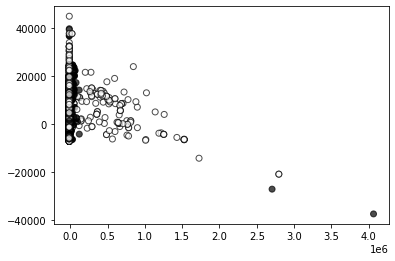

In [18]:
# Plot the distribution of classes after a dimensionality reduction with PCA (two dimensions)
X_train, X_test, y_train, y_test = train_test_split(X_binary_resampled, Y_binary_resampled, test_size=0.3) # 70% training and 30% test
build_and_test(X_train, X_test, y_train, y_test)

Secondly, we have to define some functions to plot the importance of network features.

In [19]:
def fromListToSortedDict(elementList, reverse=False):
  i=0
  d={}

  network_feature_name_list = list(X.keys())

  for element in elementList:
    d[network_feature_name_list[i]] = element
    i = i+1

  return dict(sorted(d.items(), key=lambda item: abs(item[1]), reverse=reverse))

def printTopFeatures(dict_as_list, top=10):

  d = fromListToSortedDict(dict_as_list, reverse=True)

  result = []

  i=0
  for key,val in d.items():
    i +=1
    print("#{place} Feature: {feature}, coefficient: {coef}".format(place=i, feature=key, coef=val))
    result.append(key)

    if(i==top):
      break

  return result

def drawNetworkFeatureImportance(importance_list, plot_title):
    importance_dict = fromListToSortedDict(importance_list)

    name_list = list(importance_dict.keys())
    coefficient_list = list(importance_dict.values())

    plt.title(plot_title)
    plt.barh(range(len(name_list)), coefficient_list, align='center')
    plt.yticks(range(len(name_list)), name_list)
    plt.show()

## 3.1 Random Forest

Here we have two cases to examine; one per each labeling technique (binary or 3-class classification)

First let's define some useful methods:

### 3.1.1 Binary classification

Binary Classification


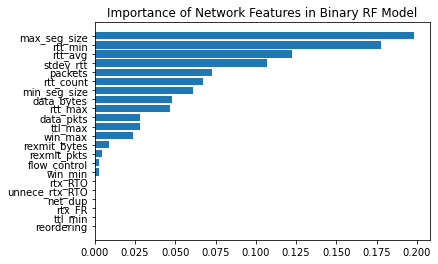

#1 Feature: max_seg_size, coefficient: 0.19803644256128528
#2 Feature: rtt_min, coefficient: 0.17780958505152333
#3 Feature: rtt_avg, coefficient: 0.12271099862060825
#4 Feature: stdev_rtt, coefficient: 0.1068934250892862
#5 Feature: packets, coefficient: 0.07271098833761526
#6 Feature: rtt_count, coefficient: 0.06721699398670328
#7 Feature: min_seg_size, coefficient: 0.06075690379204685
#8 Feature: data_bytes, coefficient: 0.047879193508856346
#9 Feature: rtt_max, coefficient: 0.04688767289272151
#10 Feature: data_pkts, coefficient: 0.02826452118798926
#11 Feature: ttl_max, coefficient: 0.028057897435505356
#12 Feature: win_max, coefficient: 0.02386680913694871


In [20]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model = RandomForestClassifier()

# Keep the binary classification label
X = X_normal
y = Y_normal.iloc[:, 0]

# fit the model
model.fit(X, y)

# get importance
rf_importance_binary = model.feature_importances_

print("Binary Classification")
drawNetworkFeatureImportance(rf_importance_binary, "Importance of Network Features in Binary RF Model")
top_features = printTopFeatures(rf_importance_binary, 12)

#### **Evaluate model performance**

Now let's test the accuracy that our ML models can have.  We will do the following steps:

1. First we need to keep the features and labels that we want
2. Split the dataset into train and test (e.g. 30% split)
3. Train the model
4. Make some predictions over the test dataset
5. Print accuracy of our model

In [21]:
from sklearn.model_selection import train_test_split

X = X_normal

y = Y_normal.iloc[:, 0] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))


Accuracy: 0.93140589569161


Testing the performance with the resampled dataset.

Accuracy: 0.9623333333333334
[[1416   28]
 [  85 1471]]


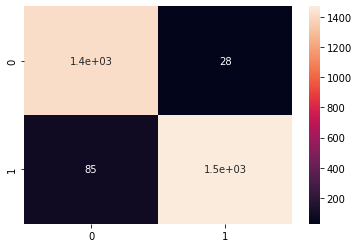

In [22]:
X = X_binary_resampled

y = Y_binary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix

# Model Accuracy, how often is the classifier correct?
y_pred = model.predict(X_test)
print("Accuracy:",model.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

In [23]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
accuracies.mean()

0.9638571428571427

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


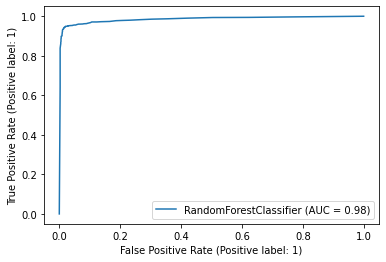

In [24]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_test, y_test)

Is there any difference between modeling with all features or only a few of them? Testing with the top_features:

In [25]:
X = X_binary_resampled[top_features]

y = Y_binary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix

# Model Accuracy, how often is the classifier correct?
y_pred = model.predict(X_test)
print("Accuracy:",model.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.9643333333333334
[[1497   25]
 [  82 1396]]


### 3.1.2 Ternary classification

Ternary Classification


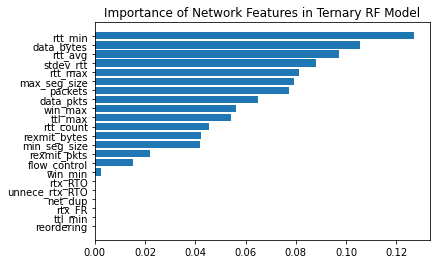

#1 Feature: rtt_min, coefficient: 0.12693118103467774
#2 Feature: data_bytes, coefficient: 0.10573944171607294
#3 Feature: rtt_avg, coefficient: 0.0973733472667016
#4 Feature: stdev_rtt, coefficient: 0.08806401113713246
#5 Feature: rtt_max, coefficient: 0.08135545918136795
#6 Feature: max_seg_size, coefficient: 0.07919500478286035
#7 Feature: packets, coefficient: 0.07723828551700583
#8 Feature: data_pkts, coefficient: 0.06487165720730957
#9 Feature: win_max, coefficient: 0.05607993854695961
#10 Feature: ttl_max, coefficient: 0.05408142474856548
#11 Feature: rtt_count, coefficient: 0.04546321923427986
#12 Feature: rexmit_bytes, coefficient: 0.042460818437169826


In [26]:
# Keep the ternary classification label

X = X_normal

y = Y_normal.iloc[:, 1]

# fit the model
model.fit(X, y)

# get importance
rf_importance_ternary = model.feature_importances_

print("Ternary Classification")
drawNetworkFeatureImportance(rf_importance_ternary, "Importance of Network Features in Ternary RF Model")
top_features = printTopFeatures(rf_importance_ternary, 12)

#### Evaluate model performance
As before we will train and test the model

In [27]:
X = X_normal[top_features]

y = Y_normal.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))

Accuracy: 0.7465986394557823


Let's execute it with upsampling. To have a balanced dataset.

Accuracy: 0.914
[[1512    0    0]
 [  18 1290  161]
 [   5  203 1311]]


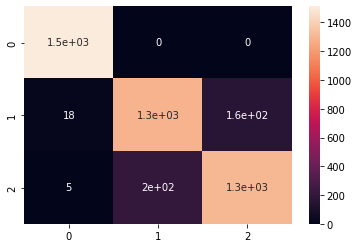

In [28]:
X = X_ternary_resampled

y = Y_ternary_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

## 3.2 Support Vector Machine


### 3.2.1 Binary Classification

Binary Classification


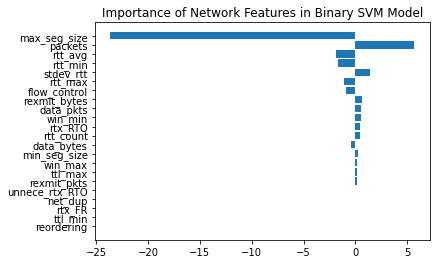

#1 Feature: max_seg_size, coefficient: -23.671830153112833
#2 Feature: packets, coefficient: 5.697757853214617
#3 Feature: rtt_avg, coefficient: -1.909297886695146
#4 Feature: rtt_min, coefficient: -1.6625409892982956
#5 Feature: stdev_rtt, coefficient: 1.3923247839531112
#6 Feature: rtt_max, coefficient: -1.1434873477685852
#7 Feature: flow_control, coefficient: -0.92156097041888
#8 Feature: rexmit_bytes, coefficient: 0.6801926024236087
#9 Feature: data_pkts, coefficient: 0.5855570147315149
#10 Feature: win_min, coefficient: 0.500020266577474
#11 Feature: rtx_RTO, coefficient: 0.43014219753677896
#12 Feature: rtt_count, coefficient: 0.40495275342014103
#13 Feature: data_bytes, coefficient: -0.3980033388033146
#14 Feature: min_seg_size, coefficient: 0.2152870642510709
#15 Feature: win_max, coefficient: 0.14272959854238088
#16 Feature: ttl_max, coefficient: 0.1364446708137475


In [29]:
from sklearn.preprocessing import MinMaxScaler
# random forest for feature importance on a regression problem
from sklearn import svm

model = svm.SVC(kernel='linear')

#Important for the fitting to finish. Or else it goes forever
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X_normal)

X = pd.DataFrame(scaled_data, columns=X_normal.keys())
y = Y_normal.iloc[:, 0]

model.fit(X, y)

svm_importance_binary = (model.coef_[0])

print("Binary Classification")
drawNetworkFeatureImportance(svm_importance_binary, "Importance of Network Features in Binary SVM Model")
topFeatures = printTopFeatures(svm_importance_binary, 16)

In [30]:
#Important for the fitting to finish. Or else it goes forever
scaler = MinMaxScaler()

X = X_normal[topFeatures]

scaled_data = scaler.fit_transform(X)

X = pd.DataFrame(scaled_data, columns=X.keys())
y = Y_normal.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model.fit(X_train, y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))

Accuracy: 0.9226190476190477


Let's execute it with upsampling. To have a balanced dataset.:

In [31]:
scaler = MinMaxScaler()

X = X_binary_resampled[topFeatures]

scaled_data = scaler.fit_transform(X)

X = pd.DataFrame(scaled_data, columns=X.keys())
y = Y_binary_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model.fit(X_train, y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))

Accuracy: 0.924


### 3.2.2 Ternary Classification

Ternary Classification


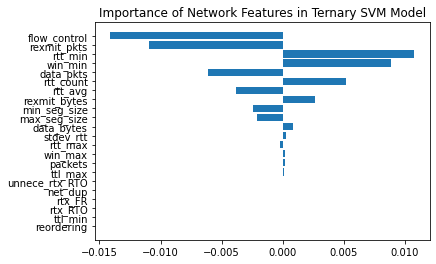

#1 Feature: flow_control, coefficient: -0.014135021587104309
#2 Feature: rexmit_pkts, coefficient: -0.010934010271636208
#3 Feature: rtt_min, coefficient: 0.010770753334481409
#4 Feature: win_min, coefficient: 0.008832973969039593
#5 Feature: data_pkts, coefficient: -0.006120419713643521
#6 Feature: rtt_count, coefficient: 0.005138462410467781
#7 Feature: rtt_avg, coefficient: -0.0038493249073940916
#8 Feature: rexmit_bytes, coefficient: 0.002641800261439231
#9 Feature: min_seg_size, coefficient: -0.0024743535993859977
#10 Feature: max_seg_size, coefficient: -0.002139604190567468
#11 Feature: data_bytes, coefficient: 0.0007998745951667274
#12 Feature: stdev_rtt, coefficient: 0.0002949577050834762


In [32]:
model = svm.SVC(kernel='linear')

#Important for the fitting to finish. Or else it goes forever
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X_normal)

X = pd.DataFrame(scaled_data, columns=X_normal.keys())
y = Y_normal.iloc[:, 1]

model.fit(X, y)

svm_importance_binary = (model.coef_[0])

print("Ternary Classification")
drawNetworkFeatureImportance(svm_importance_binary, "Importance of Network Features in Ternary SVM Model")
topFeatures = printTopFeatures(svm_importance_binary, 12)

In [33]:
#Important for the fitting to finish. Or else it goes forever
scaler = MinMaxScaler()

X = X_normal[topFeatures]

scaled_data = scaler.fit_transform(X)

X = pd.DataFrame(scaled_data, columns=X.keys())
y = Y_normal.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model.fit(X_train, y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))

Accuracy: 0.7335600907029478


Let's execute it with upsampling. To have a balanced dataset.:

In [34]:
#Important for the fitting to finish. Or else it goes forever
scaler = MinMaxScaler()

X = X_ternary_resampled[topFeatures]

scaled_data = scaler.fit_transform(X)

X = pd.DataFrame(scaled_data, columns=X.keys())
y = Y_ternary_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

model.fit(X_train, y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_test, y_test))

Accuracy: 0.5711111111111111


## 3.3 XGBoost with up-sampled data

### 3.3.1 Binary Classification

In [35]:
from xgboost import XGBClassifier
X = X_binary_resampled
y = Y_binary_resampled 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
xgb_2 = XGBClassifier()
xgb_2.fit(X_train, y_train)
y_pred = xgb_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy:",xgb_2.score(X_test, y_test))


[[1446   39]
 [ 137 1378]]
Accuracy: 0.9413333333333334


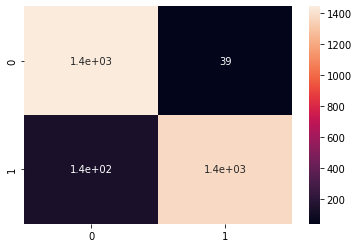

In [36]:
import seaborn as sns
sns.heatmap(cm, annot=True)

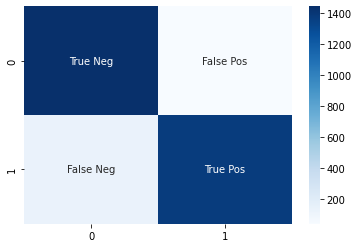

In [37]:
import numpy as np
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


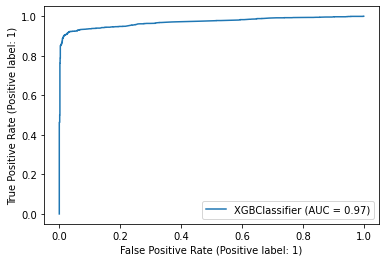

In [38]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_2, X_test, y_test)

### 3.3.2 Ternary Classification



In [39]:
from xgboost import XGBClassifier
X = X_ternary_resampled
y = Y_ternary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

xgb_3 = XGBClassifier()
xgb_3.fit(X_train, y_train)
y_pred = xgb_3.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy:",xgb_3.score(X_test, y_test))

[[1194  280   15]
 [ 163 1083  274]
 [  63  329 1099]]
Accuracy: 0.7502222222222222


## 3.4 Decision Tree

### 3.4.1 Binary Classification

In [40]:
from sklearn import tree

X = X_binary_resampled
y = Y_binary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("Accuracy:",clf.score(X_test, y_test))

Accuracy: 0.9423333333333334


### 3.4.2 Ternary Classification

In [41]:
X = X_ternary_resampled
y = Y_ternary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("Accuracy:",clf.score(X_test, y_test))

Accuracy: 0.884


# 4 Generalizable (Random Forest ML model only)

In this section we will test whether our Random Forest model is generalizable using the upsampled dataset

In [42]:
dataset_filename = list(generalized.keys())[0]

# Read in data and display first rows
df_generalized = pd.read_csv(dataset_filename)

In [43]:
threshold=1
high_quality_threshold=2
low_quality_threshold=3

df_generalized.loc[(df_generalized['stallCount']<threshold), 'qoe_class_1'] = "0" # Stands for good quality
df_generalized.loc[(df_generalized['stallCount']>=threshold), 'qoe_class_1'] = "1" # Stands for bad quality

df_generalized.loc[(df_generalized['qualityChanges']<high_quality_threshold), 'qoe_class_2'] = "0" # Stands for good quality
df_generalized.loc[(df_generalized['qualityChanges']>=high_quality_threshold) & (df_generalized['qualityChanges']<=low_quality_threshold), 'qoe_class_2'] = "1" # Stands for medium quality
df_generalized.loc[(df_generalized['qualityChanges']>low_quality_threshold), 'qoe_class_2'] = "2" # Stands for bad quality


X_generalized_test=df_generalized.iloc[:, 3:-7]

scaled_data = scaler.fit_transform(X_generalized_test)
X_generalized_test_scaled=pd.DataFrame(scaled_data, columns=X_generalized_test.keys())

y_generalized_test=df_generalized.iloc[:, -2:]

## 4.1 Binary Classification



In [44]:
X_train = X_binary_resampled
y_train = Y_binary_resampled 

X_test = X_generalized_test
y_test = y_generalized_test.iloc[:, 0]

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)
print("Accuracy:",model.score(X_test, y_test))

print("What if I rescale")

scaled_data = scaler.fit_transform(X_train)
X_train_scaled=pd.DataFrame(scaled_data, columns=X_generalized_test.keys())

model.fit(X_train_scaled,y_train)
print("Accuracy:",model.score(X_generalized_test_scaled, y_test))


Accuracy: 0.8619883040935673
What if I rescale
Accuracy: 0.8760233918128655


## 4.2 Ternary Classification

In [45]:
X_train = X_ternary_resampled
y_train = Y_ternary_resampled 

X_test = X_generalized_test
y_test = y_generalized_test.iloc[:, 1]

model = RandomForestClassifier(n_estimators=100)

model.fit(X_train,y_train)
print("Accuracy:",model.score(X_test, y_test))

print("What if I rescale")

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)
X_train_scaled=pd.DataFrame(scaled_data, columns=X_train.keys())

model.fit(X_train_scaled,y_train)
print("Accuracy:",model.score(X_generalized_test_scaled, y_test))

Accuracy: 0.38421052631578945
What if I rescale
Accuracy: 0.30701754385964913


# 5 Optimizations (Random Forest ML model only)

In this point we will perform optimizations for the Random Forest machine learning model that is proven to be the best model. The optimizations are incremental in the sence that the each optimization is applied to the already existing optimizations. We measure the performance with the existing dataset as well as a generalized dataset

## 5.1 Univariate Feature Selection

### 5.1.1 Binary Classification

In [46]:
# Univariate Feature Selection with SelectKBest

from sklearn.feature_selection import SelectKBest, mutual_info_regression

# select top 5 features
selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(X_binary_resampled, Y_binary_resampled)
binary_relevant_features = X_binary_resampled.columns[selector.get_support()]
binary_relevant_features

Index(['rtt_avg', 'rtt_min', 'ttl_max', 'max_seg_size', 'min_seg_size'], dtype='object')

In [47]:
X = X_binary_resampled[binary_relevant_features]

y = Y_binary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

binary_model_5_2 = RandomForestClassifier(n_estimators=100)

binary_model_5_2.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",binary_model_5_2.score(X_test, y_test))

Accuracy: 0.961


### 5.1.2 Ternary Classification

In [48]:
# select top 5 features
selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(X_ternary_resampled, Y_ternary_resampled)
ternary_relevant_features = X_ternary_resampled.columns[selector.get_support()]
ternary_relevant_features

Index(['data_bytes', 'rtt_avg', 'rtt_min', 'rtt_max', 'stdev_rtt'], dtype='object')

In [49]:
X = X_ternary_resampled[ternary_relevant_features]

y = Y_ternary_resampled 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

ternary_model_5_2 = RandomForestClassifier(n_estimators=100)

ternary_model_5_2.fit(X_train,y_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",ternary_model_5_2.score(X_test, y_test))

Accuracy: 0.898


## 5.2 Cross Validation

### 5.1.1 Binary Classification

In [50]:
# k fold cross validation
from sklearn.model_selection import cross_val_score

binary_model = RandomForestClassifier(n_estimators=100)

accuracies = cross_val_score(estimator = binary_model, X = X_binary_resampled[binary_relevant_features], y = Y_binary_resampled, cv = 10)
accuracies.mean()

0.9637999999999998

### 5.1.2 Ternary Classification

In [51]:
ternary_model = RandomForestClassifier(n_estimators=100)

accuracies = cross_val_score(estimator = ternary_model, X = X_ternary_resampled[ternary_relevant_features], y = Y_ternary_resampled, cv = 10)
accuracies.mean()

0.9165999999999999

# 6 Final Model

In [52]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## 6.1 Binary Classification

In [53]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, n_jobs = 1)

In [54]:
X = X_binary_resampled[binary_relevant_features]
y = Y_binary_resampled 

print("First approach")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

rf_random.fit(X_train,y_train)
print(rf_random.score(X_test, y_test)) # Accuracy 0.966

print("Generalized?")

X_train = X
y_train = y

X_test = X_generalized_test[binary_relevant_features]
y_test = y_generalized_test.iloc[:, 0]

rf_random.fit(X_train,y_train)
print("Accuracy:",rf_random.score(X_test, y_test)) # Accuracy 0.704

print("With scaling...")

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_train=pd.DataFrame(scaled_data, columns=X.keys())

y_train = y

X_test = X_generalized_test_scaled[binary_relevant_features]
y_test = y_generalized_test.iloc[:, 0]

rf_random.fit(X_train,y_train)
print("Accuracy:",rf_random.score(X_test, y_test)) # Accuracy 0.833


First approach
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

0.958
Generalized?
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

Accuracy: 0.7029239766081872
With scaling...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

Accuracy: 0.8005847953216374


## 6.2 Ternary Classification

In [55]:
rf_random_ternary = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 50, cv = 3, verbose=1,  n_jobs = 1)

In [56]:
X = X_ternary_resampled[ternary_relevant_features]
y = Y_ternary_resampled 

print("First approach")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

rf_random_ternary.fit(X_train,y_train)
print("Accuracy:",rf_random_ternary.score(X_test, y_test))

print("Generalized?")

X_train = X
y_train = y

X_test = X_generalized_test[ternary_relevant_features]
y_test = y_generalized_test.iloc[:, 1]

rf_random_ternary.fit(X_train,y_train)
print("Accuracy:",rf_random_ternary.score(X_test, y_test))

print("With scaling...")

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)
X_train=pd.DataFrame(scaled_data, columns=X.keys())

y_train = y

X_test = X_generalized_test_scaled[ternary_relevant_features]
y_test = y_generalized_test.iloc[:, 1]

rf_random_ternary.fit(X_train,y_train)
print("Accuracy:",rf_random_ternary.score(X_test, y_test))

First approach
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

Accuracy: 0.9026666666666666
Generalized?
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

Accuracy: 0.4251461988304094
With scaling...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 384, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 140, in _validate_estimator
    self.n_estimators
ValueError: n_estimators must be greater than zero, got 0.

  

Accuracy: 0.2789473684210526


# 7. Summary-Results

In [57]:
from google.colab import data_table
data_table.enable_dataframe_formatter()



## 7.1 Model Comparison



The following table summarizes the result with the train dataset of ~11K sessions with upsampling. For 

||RF|SVM|XGBoost|Decision Tree|
|---|-----|---|---|---|
|Binary|**0.97**|0.93|0.94|0.93|
|Ternary|**0.92**|0.58|0.75|0.89|

## 7.2 Generalization

We focus on the best ML model which is Random Forest.

After we trained our ML model using the ~11K sessions, we tried to test our model with sessions produced under different conditions (ethernet, vpn, bandwidth, session duration).

We compare the normal accuracy score of the random forest with the test accuracy derived from the generalized dataset. As you may notice the accuracy drops. In order to make our model robust, we tried to rescale the network features using the rescale function of scikit library [Interesting link about normalization/standardization](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79)

|Random Forest|Normal|Generalized|Generalized (Rescaled)|
|---|-----|---|---|
|Binary|**0.97**|0.83|0.88|
|Ternary|**0.92**|0.37|0.31|

## 7.3 Feature Selection



Let's see how feature selection impacts performance of ML models:

We used the univariate feature selection algorithm.

|Random Forest|24 Features|5 Features|
|---|-----|---|
|Binary|**0.966**|0.955|
|Ternary|**0.914**|0.906|

## 7.4 Cross Validation


Finally we performed cross validation to our ML model to make it robust.

* For the binary classification we performed 100 iterations with 3 Cross validations (3*100 = 300 iterations)

* For the ternary classification we performed 10 iterations with 3 Cross Validations (3*10 = 30 iterations).

* The models have been trained using the 5 most important features as selected above.

* The features are rescaled to make the model as generalizable as possible.

* The performance is measured over the same dataset and over a generalized dataset.

Results:

|Random Forest|Test w\ Same Dataset| Test w\ Generalized Dataset and Rescaled
|---|-----|---|
|Binary|**0.966**|0.833|
|Ternary|**0.899**|0.279|